In [1]:
%load_ext autoreload

In [39]:
import times_series_learning as tsl
import server_profile_learning as spl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import datetime as dt
import time
from logreader import read_dir
from logparser import parse_all
from loganalyzer import MessageLogAnalyzer, describe, print_description, print_clusters
import class_time_series
import pandas as pd
import numpy as np
%autoreload 



In [3]:
pwd

'/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/LogKiller'

In [4]:
LogPath = '/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/logs/analytics'
p = class_time_series.GetServerData(LogPath)
ServerName = p.ServerList()

In [5]:
#Server present the 19/10/2017
ServerPresent1910 =ServerName.columns[ServerName.loc['2017-10-19'] !=0]
ServerPresent1910

Index(['10.60.64.53', 'airfrance.fr', 'centos.localdomain', 'g',
       'qviqbocpmg04', 'qvirbkarno10', 'qvirnascgo02', 'qvirnmonlx02',
       'qvisbcld0084', 'qvisbcld0146.novalocal', 'qvisbcldaa20',
       'qvisbcldaa22', 'qvisbcldaa35', 'qvisbcldaa36', 'qvisbcldaa38',
       'qvisbcldaa46', 'qvisbcldaa60', 'qvisbcldaa62', 'qvisbcldaa64',
       'qvisbcldaa66', 'qvisbcldaa68', 'qvisbcldaa70', 'qvisbcldaa72',
       'qvisbcldaa74', 'qvisbcldaa76', 'qvisbcldaa78', 'qvisbcloud12',
       'qvisbcloud22', 'qvisbcloud24', 'qvisbcloud28', 'qvisbcloud30',
       'qvisbcloud46', 'qvisbcloud48', 'qvisbcloud54', 'qvisbcloud58',
       'qvisbcloud64', 'qvisbcloud72', 'qvisbcloud88', 'qvisbcloud92',
       'qvisbcloud98', 'redhat.localdomain', 'tlssbcld0055',
       'tlssbcld0055.novalocal'],
      dtype='object')

In [6]:
ServerName.loc[:,ServerPresent1910]

10.60.64.53  \
2017-04-01                                                  0   
2017-04-02                                                  0   
2017-04-03                                                  0   
2017-04-04                                                  0   
2017-04-05                                                  0   
2017-04-06                                                  0   
2017-04-07                                                  0   
2017-04-08                                                  0   
2017-04-09                                                  0   
2017-04-12                                                  0   
2017-04-18                                                  0   
2017-04-19                                                  0   
2017-04-20                                                  0   
2017-04-21                                                  0   
2017-04-22                                                  0   
2017-04-23                                                  0   
2017-04-24                                                  0   
2017-04-25                                                  0   
2017-04-26                                                  0   
2017-04-27                                                  0   
2017-04-28                                                  0   
2017-04-29                                                  0   
2017-04-30                                                  0   
2017-09-30                                                  0   
2017-10-01                                                  0   
2017-10-02                                                  0   
2017-10-03                                                  0   
2017-10-04                                                  0   
2017-10-06                                                  0   
2017-10-08                                                  0   
2017-10-10                                                  0   
2017-10-11                                                  0   
2017-10-16                                                  0   
2017-10-18                                                  0   
2017-10-19  /home/joseph/Dropbox/DeepLearning/ProjetFilRou...   
2017-10-20                                                  0   
2017-10-21                                                  0   
2017-10-24                                                  0   
2017-10-26                                                  0   

                                                 airfrance.fr  \
2017-04-01                                                  0   
2017-04-02                                                  0   
2017-04-03                                                  0   
2017-04-04                                                  0   
2017-04-05                                                  0   
2017-04-06                                                  0   
2017-04-07                                                  0   
2017-04-08                                                  0   
2017-04-09                                                  0   
2017-04-12                                                  0   
2017-04-18                                                  0   
2017-04-19                                                  0   
2017-04-20                                                  0   
2017-04-21                                                  0   
2017-04-22                                                  0   
2017-04-23                                                  0   
2017-04-24                                                  0   
2017-04-25                                                  0   
2017-04-26                                                  0   
2017-04-27                                                  0   
2017-04-28                                                  0   
2017-04-29         

In [170]:
# Select a full week for learning even if not contiguous date
date_available = ServerName[ServerName['qvirbkarno10'] != 0].index
# let 's del the 2017-10-19
date_available = np.delete(date_available, np.argwhere(date_available == '2017-10-19')[0])
# bug from 19:00 for 284 minutes without logs
print(type(date_available))
# let's take now the first full week
date_ind = np.empty(7,dtype=dt.date)
date_available_2 = np.empty(date_available.shape[0]-7,dtype=dt.date)
for i in range(7):
    d = date_available[int(np.argwhere(date_available.weekday ==i)[0])]
    date_available = np.delete(date_available, np.argwhere(date_available == d)[0])
    date_ind[i]= dt.date.fromtimestamp(d.timestamp())
date_available_2 =[dt.date.fromtimestamp(d.timestamp()) for d in date_available]
print(date_available_2)
print(date_ind)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
[datetime.date(2017, 10, 8), datetime.date(2017, 10, 10), datetime.date(2017, 10, 11), datetime.date(2017, 10, 16), datetime.date(2017, 10, 18), datetime.date(2017, 10, 20), datetime.date(2017, 10, 21), datetime.date(2017, 10, 24)]
[datetime.date(2017, 10, 2) datetime.date(2017, 10, 3)
 datetime.date(2017, 10, 4) datetime.date(2017, 10, 26)
 datetime.date(2017, 10, 6) datetime.date(2017, 9, 30)
 datetime.date(2017, 10, 1)]


In [8]:
#best choice qvirbkarno
log_data_list = ServerName.loc[:,'qvirbkarno10'].values
log_data_list = [i for i in log_data_list if i !=0 ]
log_data_list

['/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/logs/analytics/qvirbkarno10.20170930.log',
 '/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/logs/analytics/qvirbkarno10.20171001.log',
 '/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/logs/analytics/qvirbkarno10.20171002.log',
 '/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/logs/analytics/qvirbkarno10.20171003.log',
 '/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/logs/analytics/qvirbkarno10.20171004.log',
 '/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/logs/analytics/qvirbkarno10.20171006.log',
 '/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/logs/analytics/qvirbkarno10.20171008.log',
 '/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/logs/analytics/qvirbkarno10.20171010.log',
 '/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/logs/analytics/qvirbkarno10.20171011.log',
 '/home/joseph/Dropbox/DeepLearning/ProjetFilRouge/AirFrance/log

In [9]:
#Log Clustering

analyzer = MessageLogAnalyzer()

# Import des logs
logs = read_dir('../logs/analytics/*qvirbkarno10*')

# Parsing des logs en df
df_log = parse_all(logs)

# Extraction de la partie message
X = df_log.loc[:,2:].values

# Count des fréquences verticales
X_count = analyzer.fit_count(X) # "batch"

# Obtention des labels de clustering
y = analyzer.fit_clusterize(X,X_count)

# Stockage des labels de clustering
df_log['label'] = y

df_log.to_csv('dataframe.csv')

../logs/analytics/qvirbkarno10.20171024.log
../logs/analytics/qvirbkarno10.20171004.log
../logs/analytics/qvirbkarno10.20171006.log
../logs/analytics/qvirbkarno10.20171021.log
../logs/analytics/qvirbkarno10.20171019.log
../logs/analytics/qvirbkarno10.20171008.log
../logs/analytics/qvirbkarno10.20171002.log
../logs/analytics/qvirbkarno10.20171020.log
../logs/analytics/qvirbkarno10.20170930.log
../logs/analytics/qvirbkarno10.20171026.log
../logs/analytics/qvirbkarno10.20171016.log
../logs/analytics/qvirbkarno10.20171011.log
../logs/analytics/qvirbkarno10.20171001.log
../logs/analytics/qvirbkarno10.20171003.log
../logs/analytics/qvirbkarno10.20171018.log
../logs/analytics/qvirbkarno10.20171010.log

[Sucess] 16 files loaded
[Success] Logs parsed within 0.62s
[Success] Vocabulary processed within 0.78s
[Success] 143049 Logs reduced into 70 Clusters within 8.93s


In [10]:
df_log = pd.read_csv('dataframe.csv')

In [11]:
df_log.head()

timestamp             0                                    1  \
0  2017-10-24 00:00:11  qvirbkarno10                         sshd[18258]:   
1  2017-10-24 00:00:51  qvirbkarno10                       xinetd[20976]:   
2  2017-10-24 00:00:51  qvirbkarno10                       xinetd[20976]:   
3  2017-10-24 00:01:01  qvirbkarno10                        CROND[19477]:   
4  2017-10-24 00:01:01  qvirbkarno10  run-parts(/etc/cron.hourly)[19477]:   

          2         3                             4               5       6  \
0       Did       not                       receive  identification  string   
1    START:      nrpe                           pid           18697    from   
2     EXIT:      nrpe                        status               0     pid   
3    (root)       CMD  (run-parts /etc/cron.hourly)             NaN     NaN   
4  starting  0anacron                           NaN             NaN     NaN   

                 7                8  ...    25   26   27   28   29   30   31  \
0             from  387.687.387.951  ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  387.547.159.271              NaN  ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2            18697         duration  ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3              NaN              NaN  ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4              NaN              NaN  ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    32   33 label  
0  NaN  NaN    14  
1  NaN  NaN     0  
2  NaN  NaN     0  
3  NaN  NaN     8  
4  NaN  NaN    10  

[5 rows x 36 columns]

In [12]:
date_ind

array(['2017-10-02', '2017-10-03', '2017-10-04', '2017-10-26',
       '2017-10-06', '2017-09-30', '2017-10-01'], dtype=object)

In [13]:
# I have to preprocess the dataframe, put timestamp in index in order to get
# the 3 datasets (1 for profiling, 2nd to set distributionn, 3rd to test)
df_log.index = pd.to_datetime(df_log.timestamp, format='%Y-%m-%d %H:%M:%S')

In [14]:
df_log.head()

timestamp             0  \
timestamp                                                
2017-10-24 00:00:11  2017-10-24 00:00:11  qvirbkarno10   
2017-10-24 00:00:51  2017-10-24 00:00:51  qvirbkarno10   
2017-10-24 00:00:51  2017-10-24 00:00:51  qvirbkarno10   
2017-10-24 00:01:01  2017-10-24 00:01:01  qvirbkarno10   
2017-10-24 00:01:01  2017-10-24 00:01:01  qvirbkarno10   

                                                       1         2         3  \
timestamp                                                                      
2017-10-24 00:00:11                         sshd[18258]:       Did       not   
2017-10-24 00:00:51                       xinetd[20976]:    START:      nrpe   
2017-10-24 00:00:51                       xinetd[20976]:     EXIT:      nrpe   
2017-10-24 00:01:01                        CROND[19477]:    (root)       CMD   
2017-10-24 00:01:01  run-parts(/etc/cron.hourly)[19477]:  starting  0anacron   

                                                4               5       6  \
timestamp                                                                   
2017-10-24 00:00:11                       receive  identification  string   
2017-10-24 00:00:51                           pid           18697    from   
2017-10-24 00:00:51                        status               0     pid   
2017-10-24 00:01:01  (run-parts /etc/cron.hourly)             NaN     NaN   
2017-10-24 00:01:01                           NaN             NaN     NaN   

                                   7                8  ...    25   26   27  \
timestamp                                              ...                   
2017-10-24 00:00:11             from  387.687.387.951  ...   NaN  NaN  NaN   
2017-10-24 00:00:51  387.547.159.271              NaN  ...   NaN  NaN  NaN   
2017-10-24 00:00:51            18697         duration  ...   NaN  NaN  NaN   
2017-10-24 00:01:01              NaN              NaN  ...   NaN  NaN  NaN   
2017-10-24 00:01:01              NaN              NaN  ...   NaN  NaN  NaN   

                      28   29   30   31   32   33 label  
timestamp                                                
2017-10-24 00:00:11  NaN  NaN  NaN  NaN  NaN  NaN    14  
2017-10-24 00:00:51  NaN  NaN  NaN  NaN  NaN  NaN     0  
2017-10-24 00:00:51  NaN  NaN  NaN  NaN  NaN  NaN     0  
2017-10-24 00:01:01  NaN  NaN  NaN  NaN  NaN  NaN     8  
2017-10-24 00:01:01  NaN  NaN  NaN  NaN  NaN  NaN    10  

[5 rows x 36 columns]

In [171]:
date_train = [t.isoformat() for t in date_available_2]
date_profile = [t.isoformat() for t in date_ind]
date_profile

['2017-10-02',
 '2017-10-03',
 '2017-10-04',
 '2017-10-26',
 '2017-10-06',
 '2017-09-30',
 '2017-10-01']

In [172]:
for d in date_train:
    data_train = pd.concat([data_train,df_log.loc[d,:]], axis=0)
for d in date_profile:
    data_profile = pd.concat([data_profile,df_log.loc[d,:]], axis=0)

data_test = df_log.loc['2017-10-19',:].reset_index(drop=True)
data_profile = data_profile.reset_index(drop=True)
data_train = data_train.reset_index(drop=True)

In [173]:
# Server Profile Learning (data, parameters, distribution, distribution_period, level_threshold)
%autoreload 2
import sortedcontainers
period = 1
m_avg_period = 5
dist_period = 15
dist_radius = 5
parameters = np.asarray([period, m_avg_period, dist_period, dist_radius])
distribution_period = 60*24 # 1 distribution for each day
level_threshold = 1e-2 # For defining outliers
distribution =sortedcontainers.SortedDict(sortedcontainers.SortedList())

In [174]:
server_profile = spl.ServerProfileLearning(data_profile,parameters, distribution,distribution_period,level_threshold)
server_profile.set_profile()

cluster number 0 of hostname: qvirbkarno10
cluster number 1 of hostname: qvirbkarno10
cluster number 2 of hostname: qvirbkarno10
cluster number 4 of hostname: qvirbkarno10
cluster number 5 of hostname: qvirbkarno10
cluster number 6 of hostname: qvirbkarno10
cluster number 7 of hostname: qvirbkarno10
cluster number 8 of hostname: qvirbkarno10
cluster number 9 of hostname: qvirbkarno10
cluster number 10 of hostname: qvirbkarno10
cluster number 11 of hostname: qvirbkarno10
cluster number 12 of hostname: qvirbkarno10
cluster number 13 of hostname: qvirbkarno10
cluster number 14 of hostname: qvirbkarno10
cluster number 15 of hostname: qvirbkarno10
cluster number 16 of hostname: qvirbkarno10
cluster number 17 of hostname: qvirbkarno10
cluster number 18 of hostname: qvirbkarno10
cluster number 19 of hostname: qvirbkarno10
cluster number 20 of hostname: qvirbkarno10
cluster number 21 of hostname: qvirbkarno10
cluster number 22 of hostname: qvirbkarno10
cluster number 23 of hostname: qvirbkarno

In [175]:
server_profile.server_profile.keys()

dict_keys(['qvirbkarno10_general', 'qvirbkarno10_0', 'qvirbkarno10_1', 'qvirbkarno10_2', 'qvirbkarno10_4', 'qvirbkarno10_5', 'qvirbkarno10_6', 'qvirbkarno10_7', 'qvirbkarno10_8', 'qvirbkarno10_9', 'qvirbkarno10_10', 'qvirbkarno10_11', 'qvirbkarno10_12', 'qvirbkarno10_13', 'qvirbkarno10_14', 'qvirbkarno10_15', 'qvirbkarno10_16', 'qvirbkarno10_17', 'qvirbkarno10_18', 'qvirbkarno10_19', 'qvirbkarno10_20', 'qvirbkarno10_21', 'qvirbkarno10_22', 'qvirbkarno10_23', 'qvirbkarno10_24', 'qvirbkarno10_26', 'qvirbkarno10_27', 'qvirbkarno10_32', 'qvirbkarno10_33', 'qvirbkarno10_36', 'qvirbkarno10_37', 'qvirbkarno10_38', 'qvirbkarno10_39', 'qvirbkarno10_42', 'qvirbkarno10_44', 'qvirbkarno10_46', 'qvirbkarno10_47', 'qvirbkarno10_48', 'qvirbkarno10_49', 'qvirbkarno10_50', 'qvirbkarno10_51', 'qvirbkarno10_52', 'qvirbkarno10_62', 'qvirbkarno10_64', 'qvirbkarno10_65', 'qvirbkarno10_66', 'qvirbkarno10_68'])

In [176]:
len(server_profile.server_profile.keys())

47

In [177]:
server_profile.server_profile['qvirbkarno10_general'].max_spread

16929

In [178]:
tab =server_profile.server_profile['qvirbkarno10_general'].profile.values < 1e-2

In [179]:
minutes_strange = np.argwhere(tab)

In [180]:
len(minutes_strange)*60

16920

In [181]:
import calendar
list(calendar.day_name)

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [182]:
import math
day = minutes_strange[0] /(60*24)
day = math.floor(day)
hour = math.floor((minutes_strange[0] - day*60*24)/60)

In [183]:
server_profile.server_profile['qvirbkarno10_general'].profile[day][hour]

minute
0     2.908732e+00
1     2.840610e+00
2     2.867175e+00
3     3.722646e+00
4     3.768871e+00
5     3.474059e+00
6     3.061716e+00
7     3.051430e+00
8     3.126192e+00
9     3.271826e+00
10    3.143189e+00
11    2.785991e+00
12    2.821659e+00
13    3.018049e+00
14    3.181708e+00
15    2.984756e+00
16    2.653964e+00
17    2.711636e+00
18    7.297582e-92
19    6.081318e-92
20    5.067765e-92
21    4.223138e-92
22    3.519281e-92
23    2.932735e-92
24    2.443945e-92
25    2.036621e-92
26    1.697184e-92
27    1.414320e-92
28    1.178600e-92
29    9.821669e-93
30    8.184724e-93
31    6.820603e-93
32    5.683836e-93
33    4.736530e-93
34    3.947108e-93
35    3.289257e-93
36    2.741047e-93
37    2.284206e-93
38    1.903505e-93
39    1.586254e-93
40    1.321879e-93
41    1.101566e-93
42    9.179713e-94
43    7.649760e-94
44    6.374800e-94
45    5.312334e-94
46    4.426945e-94
47    3.689121e-94
48    3.074267e-94
49    2.561889e-94
50    2.134908e-94
51    1.779090e-94
52   

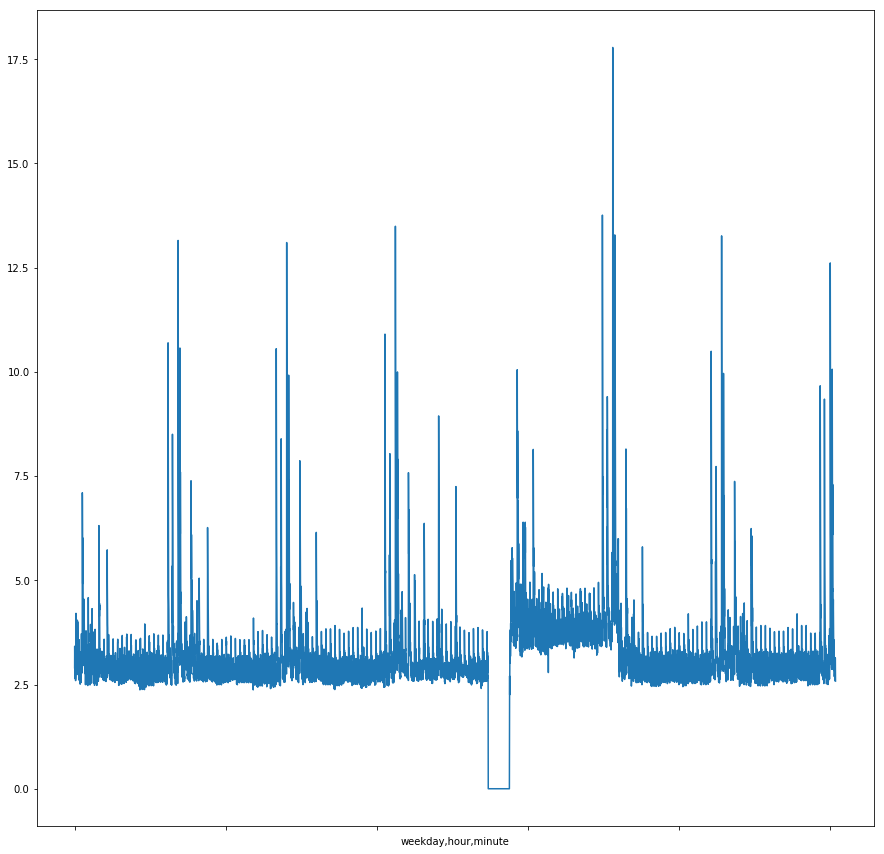

In [184]:
plt.figure(figsize=(15,15))
server_profile.server_profile['qvirbkarno10_general'].profile.plot()

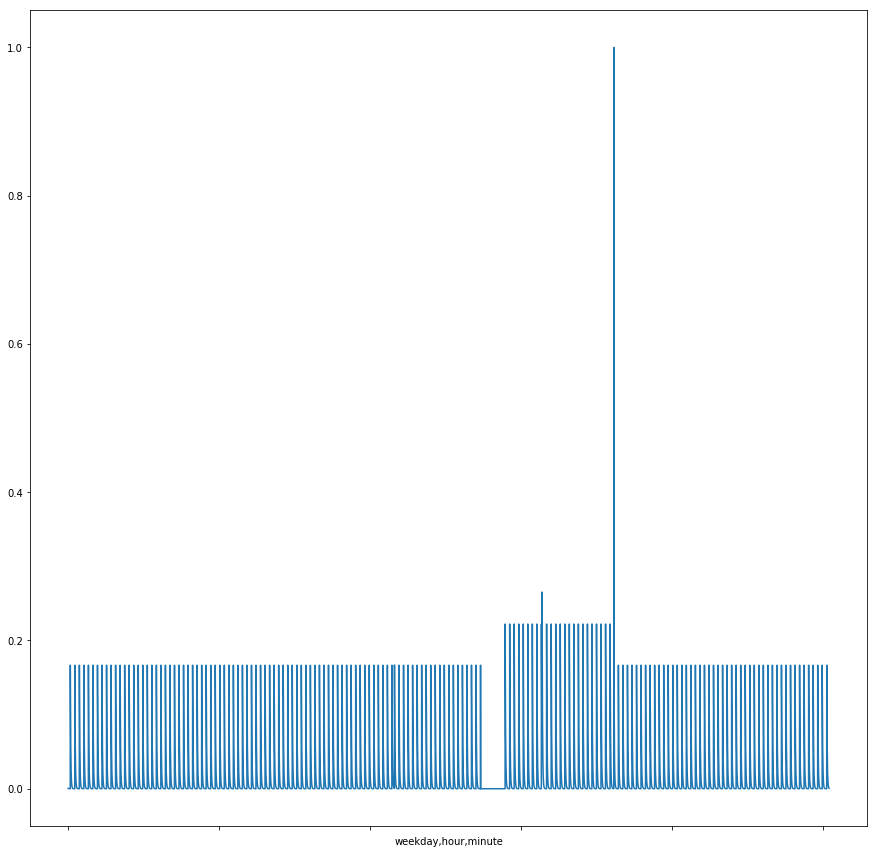

In [185]:
plt.figure(figsize=(15,15))
server_profile.server_profile['qvirbkarno10_1'].profile.plot()

In [186]:
# Streaming simulation
# data to init distribution
server_profile.level_threshold = 0
streaming_data_list = server_profile.simulate_streaming(data_train)

In [187]:
streaming_data_list[0].head(100)

timestamp             0               1       2     3  \
0   2017-10-18 00:00:00  qvirbkarno10  xinetd[20976]:  START:  nrpe   
1   2017-10-18 00:00:00  qvirbkarno10  xinetd[20976]:   EXIT:  nrpe   
2   2017-10-18 00:00:00  qvirbkarno10  xinetd[20976]:  START:  nrpe   
3   2017-10-18 00:00:00  qvirbkarno10  xinetd[20976]:   EXIT:  nrpe   
4   2017-10-18 00:00:00  qvirbkarno10  xinetd[20976]:  START:  nrpe   
5   2017-10-18 00:00:00  qvirbkarno10  xinetd[20976]:   EXIT:  nrpe   
6   2017-10-18 00:00:01  qvirbkarno10    CROND[3901]:  (root)   CMD   
7   2017-10-18 00:00:58  qvirbkarno10  xinetd[20976]:  START:  nrpe   
8   2017-10-18 00:00:59  qvirbkarno10  xinetd[20976]:   EXIT:  nrpe   
9   2017-10-18 00:00:00  qvirbkarno10  xinetd[20976]:  START:  nrpe   
10  2017-10-18 00:00:00  qvirbkarno10  xinetd[20976]:   EXIT:  nrpe   
11  2017-10-18 00:00:01  qvirbkarno10    CROND[3901]:  (root)   CMD   
12  2017-10-18 00:00:58  qvirbkarno10  xinetd[20976]:  START:  nrpe   
13  2017-10-18 00:00:59  qvirbkarno10  xinetd[20976]:   EXIT:  nrpe   

                          4     5     6                7         8  ...    25  \
0                       pid  3883  from  387.547.159.271       NaN  ...   NaN   
1                    status     0   pid             3883  duration  ...   NaN   
2                       pid  3883  from  387.547.159.271       NaN  ...   NaN   
3                    status     0   pid             3883  duration  ...   NaN   
4                       pid  3883  from  387.547.159.271       NaN  ...   NaN   
5                    status     0   pid             3883  duration  ...   NaN   
6   (/usr/lib64/sa/sa1 1 1)   NaN   NaN              NaN       NaN  ...   NaN   
7                       pid  4467  from  387.547.159.271       NaN  ...   NaN   
8                    status     0   pid             4467  duration  ...   NaN   
9                       pid  3883  from  387.547.159.271       NaN  ...   NaN   
10                   status     0   pid             3883  duration  ...   NaN   
11  (/usr/lib64/sa/sa1 1 1)   NaN   NaN              NaN       NaN  ...   NaN   
12                      pid  4467  from  387.547.159.271       NaN  ...   NaN   
13                   status     0   pid             4467  duration  ...   NaN   

     26   27   28   29   30   31   32   33 label  
0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     8  
7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     8  
12  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
13  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  

[14 rows x 36 columns]

In [189]:
anomaly, max_spread, min_spread, d, date, threshold, quant = server_profile.process_distance(streaming_data_list[0])

Anomaly Detected max_spread higher than usual 


ValueError: Invalid frequency: DatetimeIndex(['2017-10-18 00:00:00', '2017-10-18 00:01:00',
               '2017-10-18 00:02:00', '2017-10-18 00:03:00',
               '2017-10-18 00:04:00', '2017-10-18 00:05:00',
               '2017-10-18 00:06:00', '2017-10-18 00:07:00',
               '2017-10-18 00:08:00', '2017-10-18 00:09:00',
               '2017-10-18 00:10:00', '2017-10-18 00:11:00',
               '2017-10-18 00:12:00', '2017-10-18 00:13:00',
               '2017-10-18 00:14:00'],
              dtype='datetime64[ns]', freq='T')

In [96]:
 streaming_data_list[0].index = pd.to_datetime(streaming_data_list[0].timestamp, format='%Y-%m-%d %H:%M:%S')

In [97]:
 streaming_data_list[0]

timestamp             0  \
timestamp                                                
2017-10-06 04:57:33  2017-10-06 04:57:33  qvirbkarno10   
2017-10-06 04:57:38  2017-10-06 04:57:38  qvirbkarno10   
2017-10-06 04:57:38  2017-10-06 04:57:38  qvirbkarno10   
2017-10-06 04:58:07  2017-10-06 04:58:07  qvirbkarno10   
2017-10-06 04:58:07  2017-10-06 04:58:07  qvirbkarno10   
2017-10-06 04:58:20  2017-10-06 04:58:20  qvirbkarno10   

                                          1       2             3       4  \
timestamp                                                                   
2017-10-06 04:57:33          xinetd[20976]:   EXIT:          nrpe  status   
2017-10-06 04:57:38          xinetd[20976]:  START:          nrpe     pid   
2017-10-06 04:57:38          xinetd[20976]:   EXIT:          nrpe  status   
2017-10-06 04:58:07          xinetd[20976]:  START:          nrpe     pid   
2017-10-06 04:58:07          xinetd[20976]:   EXIT:          nrpe  status   
2017-10-06 04:58:20  postfix/sendmail[492]:  fatal:  unsupported:     -bt   

                         5     6                7         8  ...    25   26  \
timestamp                                                    ...              
2017-10-06 04:57:33      0   pid            32634  duration  ...   NaN  NaN   
2017-10-06 04:57:38  32646  from  387.547.159.271       NaN  ...   NaN  NaN   
2017-10-06 04:57:38      0   pid            32646  duration  ...   NaN  NaN   
2017-10-06 04:58:07  32714  from  387.547.159.271       NaN  ...   NaN  NaN   
2017-10-06 04:58:07      0   pid            32714  duration  ...   NaN  NaN   
2017-10-06 04:58:20    NaN   NaN              NaN       NaN  ...   NaN  NaN   

                      27   28   29   30   31   32   33 label  
timestamp                                                     
2017-10-06 04:57:33  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
2017-10-06 04:57:38  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
2017-10-06 04:57:38  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
2017-10-06 04:58:07  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
2017-10-06 04:58:07  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0  
2017-10-06 04:58:20  NaN  NaN  NaN  NaN  NaN  NaN  NaN     9  

[6 rows x 36 columns]

In [101]:
(streaming_data_list[0].index[1:] -  streaming_data_list[0].index[:-1]).seconds.values 

array([ 5,  0, 29,  0, 13])

In [127]:
index = pd.date_range('1/1/2000', periods=15, freq='1min')
index

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 00:01:00',
               '2000-01-01 00:02:00', '2000-01-01 00:03:00',
               '2000-01-01 00:04:00', '2000-01-01 00:05:00',
               '2000-01-01 00:06:00', '2000-01-01 00:07:00',
               '2000-01-01 00:08:00', '2000-01-01 00:09:00',
               '2000-01-01 00:10:00', '2000-01-01 00:11:00',
               '2000-01-01 00:12:00', '2000-01-01 00:13:00',
               '2000-01-01 00:14:00'],
              dtype='datetime64[ns]', freq='T')